<style>
.prompt{width: 0px; min-width: 0px; visibility: collapse}
.output_png {
    display: table-cell;
    text-align: center;
    margin:auto;
}
h1, h2 { 
  color:#000099;
}
h3, h4 { 
  color:#004d00;
}    
</style>

<p style="font-size:2.7em;color:#000099;font-weight: bold">Multiple Class Sound Event Detection</p>

**Reynaldo Vazquez**    
**June, 2019**  
[GitHub Repo](https://github.com/reyvaz/Multiple-Sound-Event-Detection)

<br>
     
This notebook builds an algorithm that automatically detects the occurrence of two classes of sound events and their onset. A deep learning network with mixed Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRU), that uses transformations of the mel spectrogram, achieves this with an event-based error rate of 0.1 and a F1-score of 0.94. 


<!--<img src="media/pow_sm.png" style="width:350px;height:250px;padding:5px" align="right">-->
<h2>Motivation</h2>

Some sound events:

- may signal the presence of an **anomaly** (i.e. machinery or vehicle malfunctions)
- or alert about the existence of an **emergency** (i.e. gun shots, glass breaks, explosions, cries for help)
- are **rare**
    - impractical to be continuously monitored by humans
    - sparsity of occurrences may cause lapses of attention (zoning out) in humans

Thus, monitoring for some sound events may be a good practice from a safety or security perspective, and automated monitoring may the be most efficient.

This project is inspired by [Task 2: Detection of rare sound events of DCASE17](http://www.cs.tut.fi/sgn/arg/dcase2017/challenge/task-rare-sound-event-detection) challenge. What differentiates this project from DCASE17's challenge is the detection of more than one class of events within one model. The classes of sound events to be detected are the occurrences of glass breaks and gun shots.

<h2>Data</h2>

Artificial sound mixes were created using background and event audio recordings from Tampere University's Detection and Classification of Acoustic Scenes and Events (DCASE) Community. 

The created artificial audio dataset and meta data can be found [here](https://zenodo.org/record/3236975#.XPSRDdNKjgt).

The source data can be found [here](http://www.cs.tut.fi/sgn/arg/dcase2017/challenge/task-rare-sound-event-detection#audio-dataset). 

 

**Created artificial sound mixes are 10 seconds long and contain:**  

- background audio from diverse scenes from start to end
- some or none glass break sounds
- some or none gunshot sounds

With this formula, two datasets were created separately: a training, and an evaluation dataset. These were created separately so that the backgrounds and event recordings used for the evaluation dataset were not used in any of the training audio mixes. Thus, keeping them unseen by the system during development. Meta-data was maintained documenting the source background, the overlaid source events, and the time onset and offset of each sound event. 



**Required libraries**

In [2]:
import os, sys, io, h5py, IPython, dcase_util, sed_eval
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import librosa, librosa.display
from scipy.io import wavfile
from tabulate import tabulate
from io import BytesIO
from zipfile import ZipFile
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, Input, TimeDistributed
from keras.layers import LSTM, Conv1D, Bidirectional, BatchNormalization, GRU
from keras.optimizers import Adam
from keras.models import load_model
%matplotlib inline

**Parameter definition**

In [3]:
track_dur = 10.0
track_dur_ms = track_dur*1000
sample_rate = 44100
mel_power = 0.5 # used for the transformation of the mel spectrogram features
lag = 0
Ty = 212 
print('Ty =', str(Ty)+',', 'is the size of the output of the last LSTM model layer')
scene_label  = 'background' # required by the event based metrics function
threshold    = 0.3  # chosen for the binary classification

Ty = 212, is the size of the output of the last LSTM model layer


**Required utilities**

In [5]:
from sed2_utils import *
from local_paths import *

## Audioset Exploration

In [6]:
zip_train = ZipFile(path_to_mixes_train, 'r')  
prefix_train = zip_train.namelist()[0]
meta_train_track = pd.read_csv(path_to_meta_track_info_train) 
meta_train_segments = pd.read_csv(path_to_meta_clip_insertions_train)

zip_eval = ZipFile(path_to_mixes_eval, 'r')
prefix_eval = zip_eval.namelist()[0]
meta_eval_track = pd.read_csv(path_to_meta_track_info_eval)
meta_eval_segments = pd.read_csv(path_to_meta_clip_insertions_eval)

In [7]:
meta_train_segments.head(3)

,trackID,event,event_start,event_end,event_file
0,10000,gunshot,5290,6849,345584_4.wav
1,10000,gunshot,2423,4602,320132_5.wav
2,10001,glassbreak,784,1223,118393_0.wav


`meta_[dataset]_segments` contain the information of where in time an event occurs within a track. Event start and end times within the track are in miliseconds

<h3>Examples of artificial audio mixes</h3>  

#### Track with mixed types of events, glass breaks and gun shots

Audio clip id:  10039


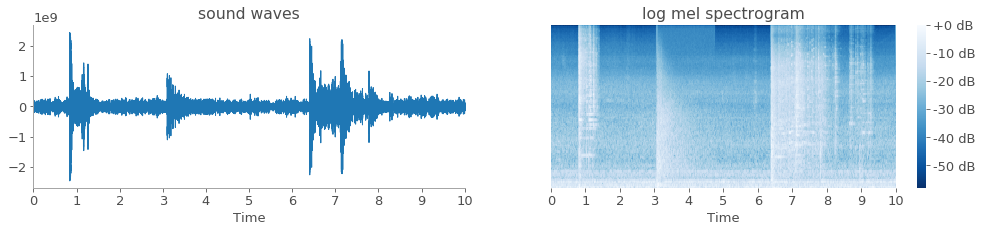

event type      start time (sec)    end time (sec)
------------  ------------------  ----------------
glassbreak                  0.83              1.42
gunshot                     3.09              4.77
glassbreak                  6.39              9.39


In [8]:
show_audio_info(zip_train, 10039, meta_train_segments, prefix_train)

#### Track with only one type of event (gunshots)

Audio clip id:  10000


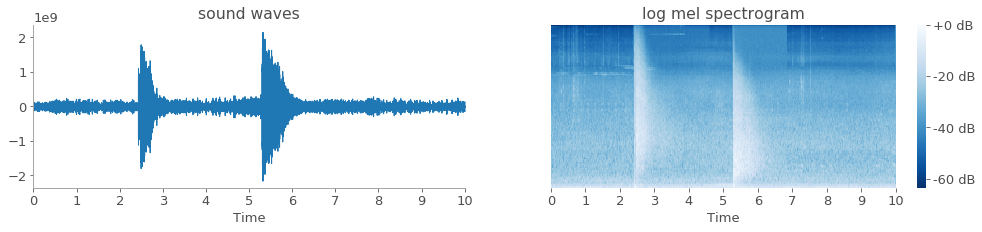

event type      start time (sec)    end time (sec)
------------  ------------------  ----------------
gunshot                     2.42              4.6
gunshot                     5.29              6.85


In [9]:
show_audio_info(zip_train, 10000, meta_train_segments, prefix_train)

#### Track with only one type of event (glass breaks)

Audio clip id:  10004


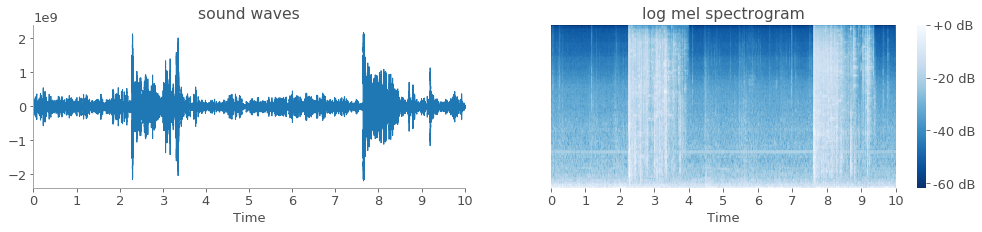

event type      start time (sec)    end time (sec)
------------  ------------------  ----------------
glassbreak                  2.27              3.99
glassbreak                  7.63              9.37


In [10]:
show_audio_info(zip_train, 10004, meta_train_segments, prefix_train)

#### Track with no events, only scene background

Audio clip id:  10022


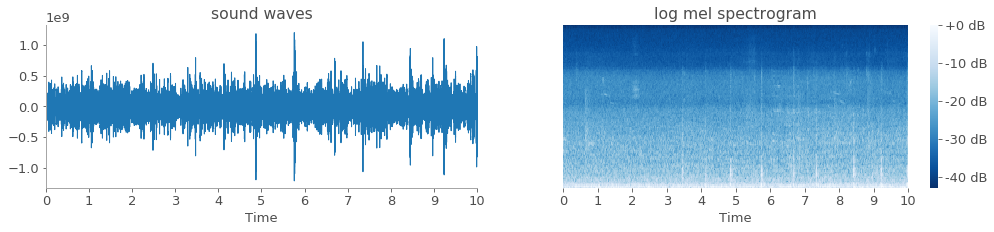

No audio events in this track, only background


In [11]:
show_audio_info(zip_train, 10022, meta_train_segments, prefix_train)

### Total sound and event content

In [12]:
%%capture
contents = {}
contents['train'] = tracks_content_info(meta_train_track, meta_train_segments, 'training', 10, 'glassbreak')
contents['eval'] = tracks_content_info(meta_eval_track, meta_eval_segments, 'evaluation', 10, 'glassbreak')

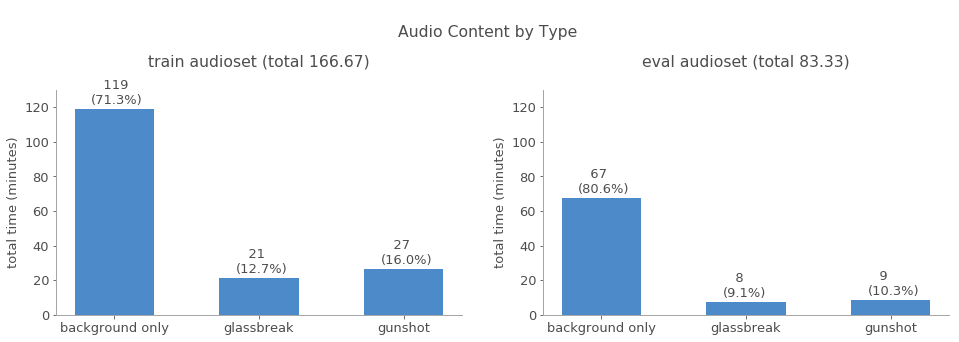

In [13]:
x_names = ('background only', 'glassbreak', 'gunshot')
plt.figure(figsize=(16, 5))
plt.suptitle('\nAudio Content by Type')
distribution_plot(contents, x_names, 130, .16, 3, 'total time (minutes)')

These plots show the totals of audio content in the datasets in seconds. Audio content is unbalanced towards background only. 

To detect the onset of an event, the system will have to make *predictions* on segments of each audio track. The length of the segments chosen for the network is 47 milliseconds (i.e. 212 segments per track). With this in mind, and because the unbalanced nature of the dataset, **event-based error rate**, as defined in [Mesaros and Heittola (2016)](http://tut-arg.github.io/sed_eval/sound_event.html) is used to evaluate the performance of the system.  The formula to calculate it is: 

![equation](https://latex.codecogs.com/gif.latex?%5Clarge%20%5Ctext%7BEvent%20Based%20Error%20Rate%7D%20%3D%20%5Cfrac%7B%5Ctext%7BSubstitutions%7D%20&plus;%20%5Ctext%7BInsertions%7D%20&plus;%20%5Ctext%7BDeletions%7D%7D%20%7B%5Ctext%7BTotal%20number%20of%20events%20in%20ground%20truth%7D%7D)

where:

- Substitutions are events in system output with correct temporal position but incorrect class label

- Insertions are events in the system output but not in ground truth and not accounted as substitutions

- Deletions are events in ground truth but not in system output and not accounted as substitutions

As can be seen, with this metric *true negative* predictions have no use or meaning, i.e. the model is not 'rewarded' for correctly predicting the abscense of an event.

## Feature Extraction

Transform audio files into the logs of the square root of the mel spectrogram

In [14]:
path_in_zip = zip_train.namelist()[1]
rate, data = get_wav_info_from_zip(path_in_zip, zip_train, sample_rate)
S = log_mel_features(data, rate, mel_power)

In [15]:
Tx = S.shape[1]  
n_freq = S.shape[0]
print('Tx =', Tx, 'number of timesteps input to the model', '\nn_freq =', n_freq)

Tx = 862 number of timesteps input to the model 
n_freq = 128


In [16]:
X_train_mel, X_eval_mel = create_or_load_mel_features(zip_train, meta_train_track, 
                                 zip_eval, meta_eval_track, Tx, n_freq, sample_rate, 
                                 mel_power, prefix_train, prefix_eval)

In [17]:
print('shape of training features set:', X_train_mel.shape)
print('shape of evaluation features set:', X_eval_mel.shape)

shape of training features set: (1000, 862, 128)
shape of evaluation features set: (500, 862, 128)


# Targets

#### Labels for each 47 *ms* audio segment using metadata

Will create the labels array. Each track is assigned a pair vectors of lenght Ty = 212. Each element of each pair of vectors corresponds to a label  $\in$ {0,1} for a ~47 milliseconds window. A 1 in the first vector corresponds to the occurrence of a glass break, whereas a 1 in the second vector corresponds to an occurrence of a gunshot.  

In [18]:
train_labels_glassbreak = create_labels(meta_train_track, meta_train_segments, Ty, track_dur_ms, 
                        1, lag, 'glassbreak')
train_labels_gunshot = create_labels(meta_train_track, meta_train_segments, Ty, track_dur_ms, 
                        1, lag, 'gunshot')

In [19]:
eval_labels_glassbreak = create_labels(meta_eval_track, meta_eval_segments,  Ty, track_dur_ms, 1, 
                       lag, 'glassbreak')
eval_labels_gunshot = create_labels(meta_eval_track, meta_eval_segments,  Ty, track_dur_ms, 1, 
                       lag, 'gunshot')

In [20]:
Y_train = np.concatenate((train_labels_glassbreak, train_labels_gunshot), axis=2)
Y_train.shape

(1000, 212, 2)

In [21]:
Y_eval = np.concatenate((eval_labels_glassbreak, eval_labels_gunshot), axis=2)
Y_eval.shape

(500, 212, 2)

## Model definition

LSTM-based model consists of 4 layers as follows 

- 1 temporal convolution (CONV1D) layer 
- 1 bidirectional-LSTM layer
- 1 bidirectional-GRU layer
- 1 time distributed dense layer as output

with batch normalization and dropout with rate of 0.5 in all but the output layer.

In [23]:
drop_rate = 0.5
def model(input_shape):
    """
    Creates the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data

    Returns:
    model -- Keras model instance
    """
    X_input = Input(shape = input_shape)
 
    X = Conv1D(256, kernel_size = 16, strides=4)(X_input)   
    X = BatchNormalization()(X)                             
    X = Activation('relu')(X)                               
    X = Dropout(drop_rate)(X)  
    
    X = Bidirectional(LSTM(units = 256, return_sequences = True))(X)
    X = Dropout(drop_rate)(X)
    X = BatchNormalization()(X)
    
    X = Bidirectional(GRU(units = 256, return_sequences = True))(X)
    X = Dropout(drop_rate)(X)
    X = BatchNormalization()(X)
    
    X = TimeDistributed(Dense(2, activation = "sigmoid"))(X)

    model = Model(inputs = X_input, outputs = X)
    return model

model = model(input_shape = (Tx, n_freq))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 862, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 212, 256)          524544    
_________________________________________________________________
batch_normalization_4 (Batch (None, 212, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 212, 256)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 212, 256)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 212, 512)          1050624   
_________________________________________________________________
dropout_5 (Dropout)          (None, 212, 512)          0         
__________

## Model Training

In [25]:
model.fit(X_train_mel, Y_train, batch_size = 64, epochs=50, verbose = 0)

In [26]:
fname = 'sed2_trained.h5'
model.save(fname)

## Model Performance 

In [27]:
model = load_model('sed2_trained.h5')

In [28]:
raw_preds_eval_mel = model.predict(X_eval_mel)
preds_eval_mel = np.copy(raw_preds_eval_mel)
preds_eval_mel = np.where(preds_eval_mel >= threshold, 1, 0)

In [29]:
gb_pred = preds_eval_mel[:,:,0].reshape(500, 212, 1)
gs_pred = preds_eval_mel[:,:,1].reshape(500, 212, 1)

segments_dicts_ref_eval_glassbreak = get_segments_ref(meta_eval_track, meta_eval_segments, 'glassbreak')
segments_dicts_ref_eval_gunshot = get_segments_ref(meta_eval_track, meta_eval_segments, 'gunshot')
segments_dicts_est_eval_glassbreak = segments_dicts_est(gb_pred, meta_eval_track, event_label = 'glassbreak')
segments_dicts_est_eval_gunshot = segments_dicts_est(gs_pred, meta_eval_track, event_label = 'gunshot')

segments_dicts_ref_eval = segments_dicts_ref_eval_glassbreak + segments_dicts_ref_eval_gunshot
segments_dicts_est_eval = segments_dicts_est_eval_glassbreak + segments_dicts_est_eval_gunshot

### Overall perfomance (in both classes)

In [30]:
ebm_eval, f1_eval, er_eval = ebm_tables(segments_dicts_ref_eval, 
                        segments_dicts_est_eval, t_col = 0.5, pct_len = 0.5, eval_offset = False)

F-measure
=========  ====
f1-score   0.94
precision  0.96
recall     0.93
=========  ==== 

Error Rate
=================  ====
error rate         0.10
substitution rate  0.01
deletion rate      0.06
insertion rate     0.03
=================  ====


### Performance on individual classes

**1 - Glassbreak**

In [31]:
ebm_eval, f1_eval, er_eval = ebm_tables(segments_dicts_ref_eval_glassbreak, 
                        segments_dicts_est_eval_glassbreak, t_col = 0.5, pct_len = 0.5, eval_offset = False)

F-measure
=========  ====
f1-score   0.97
precision  0.98
recall     0.96
=========  ==== 

Error Rate
=================  ====
error rate         0.06
substitution rate  0.00
deletion rate      0.04
insertion rate     0.02
=================  ====


**2 - Gunshot**

In [32]:
ebm_eval, f1_eval, er_eval = ebm_tables(segments_dicts_ref_eval_gunshot, 
                        segments_dicts_est_eval_gunshot, t_col = 0.5, pct_len = 0.5, eval_offset = False)

F-measure
=========  ====
f1-score   0.90
precision  0.93
recall     0.87
=========  ==== 

Error Rate
=================  ====
error rate         0.19
substitution rate  0.00
deletion rate      0.13
insertion rate     0.06
=================  ====


The two preceding reports indicate that the model is better able to detect the occurrences of glassbreaks than gunshots. I belive this can be due, at least in part, on the dificulty of correctly labeling the onset and the offset of gunshots in the dataset. Hence, I suspect the model is actually performing better at detecting gunshots than those metrics suggest. 

This can be seen below in the prediction demonstrations, in which the predictions for gunshots match the actual audio more closely than the imputed 'ground truth', which at times can be off by as much as a second. 

### Prediction Demonstrations

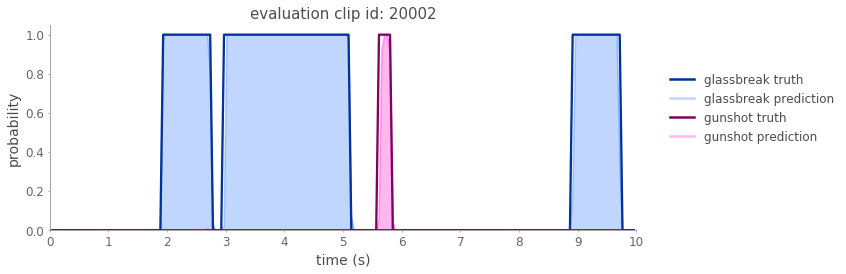

In [33]:
plot_pred_vs_true(meta_eval_track, Y_eval, raw_preds_eval_mel, 'evaluation', 
                  zip_eval, prefix_eval, track_index = 2)

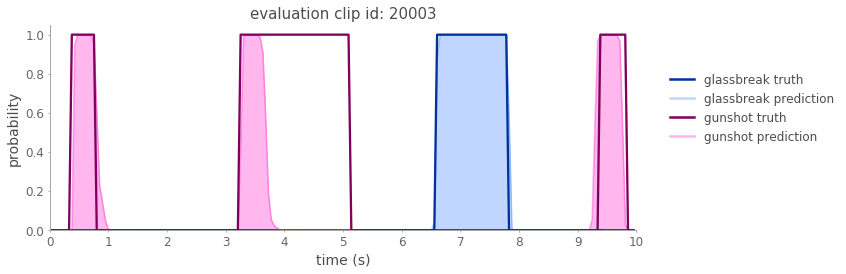

In [34]:
plot_pred_vs_true(meta_eval_track, Y_eval, raw_preds_eval_mel, 'evaluation', 
                  zip_eval, prefix_eval, track_index = 3)

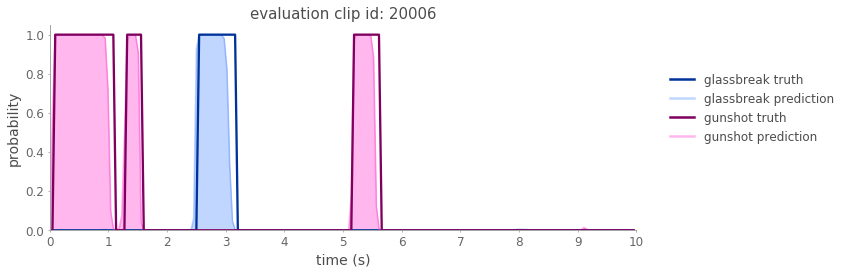

In [35]:
plot_pred_vs_true(meta_eval_track, Y_eval, raw_preds_eval_mel, 'evaluation', 
                  zip_eval, prefix_eval, track_index = 6)

## Conclusion

This project built and tested a model for the detection of two classes of sound events that may alert about the presence of an emergency. For this purpose, an artificial dataset with audio mixes, containing occurrences of glassbreaks and gunshots, was created using source recordings from Tampere's DCASE community. The dataset consists of audio clips that contain 0 to 4 mixed event occurrences.  

The model presented is a deep learning network with one temporal convolution, an LSTM layer, a GRU layer, and one time distributed dense layer as output. All but the output layers perform batch normalization, and dropout with rate of 0.5. 

The network correctly detects 93 percent of event occurrences and their onset, missing 6 percent, miscategorizing 1 percent, and falsely detecting an event at a 3 percent rate. 

#### Reference:

Annamaria Mesaros, Toni Heittola, and Tuomas Virtanen, “Metrics for polyphonic sound event detection”, Applied Sciences, 6(6):162, 2016

In [1]:
#create html report
!jupyter nbconvert sed2_main.ipynb --config html_config.py

[NbConvertApp] Converting notebook sed2_main.ipynb to html
[NbConvertApp] Writing 2552065 bytes to sed2_main.html
